# Run within one click.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms, datasets, models
import torchvision
import matplotlib.pyplot as plt

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.getcwd()

Mounted at /content/drive


'/content'

In [2]:
os.chdir('drive/MyDrive/深度学习/DarkMatterClassifier')

In [5]:
arr = np.load('train/no/1.npy')

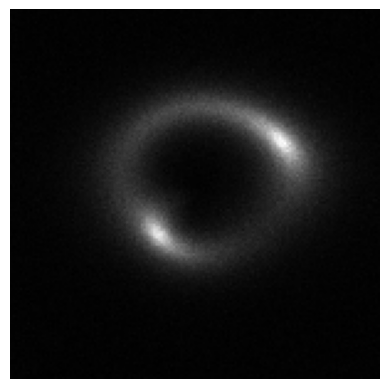

In [6]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 假设你有一个 (1, 150, 150) 的张量 tensor
tensor = torch.tensor(arr)  # 这里使用随机生成的张量作为示例

# 转换成 PIL 图像
tensor_as_image = transforms.ToPILImage()(tensor)

# 转换成灰度图像
tensor_as_image = tensor_as_image.convert("L")

# 显示图像
plt.imshow(tensor_as_image, cmap='gray')
plt.axis('off')  # 关闭坐标轴
plt.show()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class MyImageDataset(Dataset):
  def __init__(self,directories,labels):
    self.filepaths = []
    self.labels = []

    label_mapping = {label: i for i,label in enumerate(labels)}
    for directory,label in zip(directories,labels):
      files=os.listdir(directory)
      for f in files:
        self.filepaths.append(os.path.join(directory,f))
        self.labels.append(label_mapping[label])

  def __len__(self):
    return len(self.filepaths)

  def __getitem__(self,idx):
    # Load the image file at the specified index
    filepath = self.filepaths[idx]
    image = np.load(filepath)
    image = torch.tensor(image,dtype=torch.float)

    # Get the label
    label = self.labels[idx]
    return image, label

In [8]:
directories = ['train/no','train/sphere','train/vort']
labels = ['no','sphere','vort']

# Initialize our dataset
dataset = MyImageDataset(directories=directories,labels=labels)

In [9]:
batch_size = 512  # Define your batch size
shuffle = True  # Shuffle data to ensure random distribution
num_workers = 4  # Parallel threads for data loading

trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 37 * 37, 120)
        self.fc2 = nn.Linear(120, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,32*37*37)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(str(running_loss))
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print('Running Loss for this epoch is: '+str(running_loss))

print('Finished Training')

In [14]:
path = './savemodel.pth'
torch.save(net.state_dict(), path)

In [5]:
# Initialize our dataset
labels = ['no','sphere','vort']
batch_size = 512  # Define your batch size
testset = MyImageDataset(directories=['val/no','val/sphere','val/vort'],labels=labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
testnet = Net()
testnet.load_state_dict(torch.load('./savemodel.pth'))

<All keys matched successfully>

In [17]:
# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         # calculate outputs by running images through the network
#         outputs = testnet(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [7]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in labels}
total_pred = {classname: 0 for classname in labels}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        testimages, testlabels = data
        outputs = testnet(testimages)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(testlabels, predictions):
            if label == prediction:
                correct_pred[labels[label.item()]] += 1
            total_pred[labels[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: no    is 0.0 %
Accuracy for class: sphere is 24.8 %
Accuracy for class: vort  is 75.4 %
